In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder

np.random.seed(42)

N_SAMPLES = 1000
N_INPUTS = 2
CLUSTERS = 5

X, y = make_blobs(n_samples=N_SAMPLES,
                  centers=CLUSTERS,
                  n_features=N_INPUTS,
                  random_state=42,
                  cluster_std=1.5)

ohe_transformer = OneHotEncoder(sparse_output=False)
TARGETS = ohe_transformer.fit_transform(y.reshape(-1, 1))

print(f"Input features (X) shape: {X.shape}")
print(f"Output labels (Y) shape: {TARGETS.shape}")
print(f"Number of classes: {CLUSTERS}")

Input features (X) shape: (1000, 2)
Output labels (Y) shape: (1000, 5)
Number of classes: 5


In [2]:
import matplotlib.pyplot as plt

class DeepClassifier(object):
    def __init__(self, n_features, n_classes):
        inputLayerNeurons = n_features
        hiddenLayerNeurons = 10
        outLayerNeurons = n_classes

        self.learning_rate = 0.15

        self.W_Input_H1 = np.random.randn(inputLayerNeurons, hiddenLayerNeurons)
        self.W_H1_H2 = np.random.randn(hiddenLayerNeurons, hiddenLayerNeurons)
        self.W_H2_H3 = np.random.randn(hiddenLayerNeurons, hiddenLayerNeurons)
        self.W_H3_Output = np.random.randn(hiddenLayerNeurons, outLayerNeurons)

    def logistic_map(self, x, derivative=False):
        if derivative == True:
            return x * (1 - x)
        else:
            return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def propagate_forward(self, X):

        net_input_H1 = np.dot(X, self.W_Input_H1)
        self.A1_out = self.logistic_map(net_input_H1)

        net_input_H2 = np.dot(self.A1_out, self.W_H1_H2)
        self.A2_out = self.logistic_map(net_input_H2)

        net_input_H3 = np.dot(self.A2_out, self.W_H2_H3)
        self.A3_out = self.logistic_map(net_input_H3)

        output_net_input = np.dot(self.A3_out, self.W_H3_Output)
        prediction = self.softmax(output_net_input)
        return prediction

    def adjust_weights(self, X, Y_true, prediction):
        output_delta = (prediction - Y_true) / X.shape[0]

        self.W_H3_Output -= self.learning_rate * self.A3_out.T.dot(output_delta)

        H3_error = output_delta.dot(self.W_H3_Output.T)
        H3_delta = H3_error * self.logistic_map(self.A3_out, derivative=True)

        self.W_H2_H3 -= self.learning_rate * self.A2_out.T.dot(H3_delta)

        H2_error = H3_delta.dot(self.W_H2_H3.T)
        H2_delta = H2_error * self.logistic_map(self.A2_out, derivative=True)

        self.W_H1_H2 -= self.learning_rate * self.A1_out.T.dot(H2_delta)

        H1_error = H2_delta.dot(self.W_H1_H2.T)
        H1_delta = H1_error * self.logistic_map(self.A1_out, derivative=True)

        self.W_Input_H1 -= self.learning_rate * X.T.dot(H1_delta)

    def fit(self, X, Y):
        output = self.propagate_forward(X)
        self.adjust_weights(X, Y, output)

    def infer(self, X):
        return np.argmax(self.propagate_forward(X), axis=1)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, Y_train, Y_test = train_test_split(X, TARGETS, test_size=0.2, random_state=42, stratify=y)

Model_NN = DeepClassifier(n_features=N_INPUTS, n_classes=CLUSTERS)
max_iterations = 10000

for i in range(max_iterations):
    Model_NN.fit(X_train, Y_train)

Y_pred_labels = Model_NN.infer(X_test)
Y_test_labels = np.argmax(Y_test, axis=1)

accuracy = accuracy_score(Y_test_labels, Y_pred_labels)

report = classification_report(Y_test_labels, Y_pred_labels, digits=4)

print("--- Final Model Evaluation on Testing Data ---")
print(f"Overall Classification Accuracy: {accuracy:.4f}")
print("\nClassification Report (Precision, Recall, F1-Score per Class):")
print(report)

--- Final Model Evaluation on Testing Data ---
Overall Classification Accuracy: 0.9450

Classification Report (Precision, Recall, F1-Score per Class):
              precision    recall  f1-score   support

           0     1.0000    0.9500    0.9744        40
           1     0.9189    0.8500    0.8831        40
           2     1.0000    1.0000    1.0000        40
           3     0.9756    1.0000    0.9877        40
           4     0.8409    0.9250    0.8810        40

    accuracy                         0.9450       200
   macro avg     0.9471    0.9450    0.9452       200
weighted avg     0.9471    0.9450    0.9452       200



<Figure size 800x800 with 0 Axes>

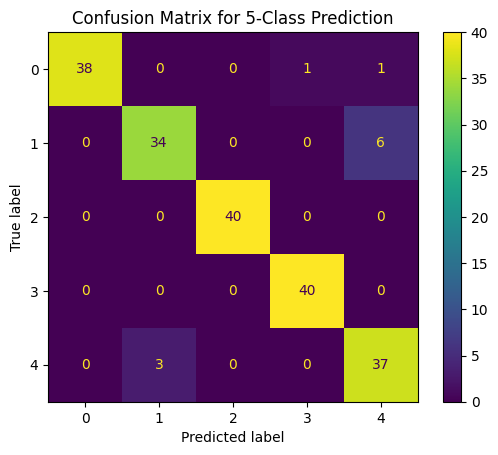

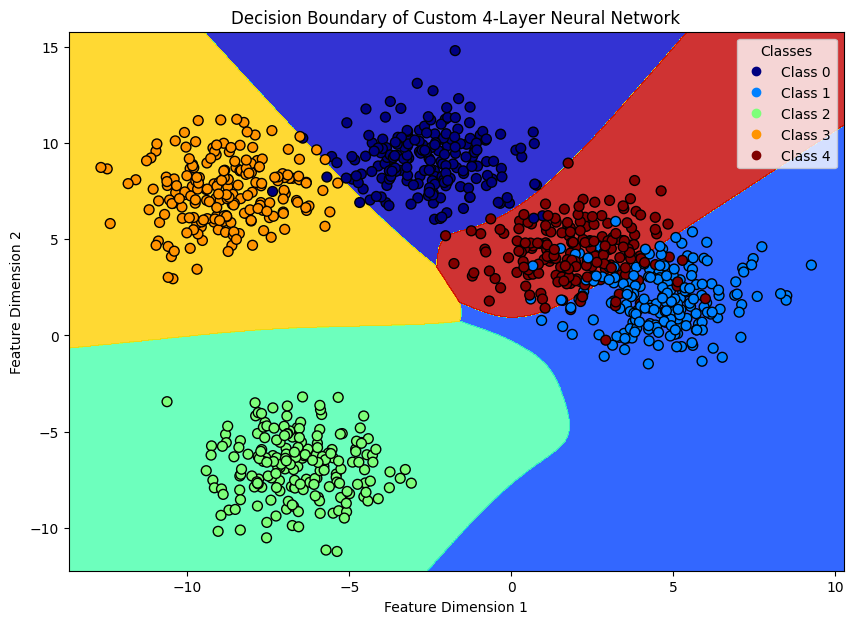

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

h = 0.02

cm = confusion_matrix(Y_test_labels, Y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ohe_transformer.categories_[0])
plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.viridis)
plt.title("Confusion Matrix for 5-Class Prediction")
plt.show()

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = Model_NN.infer(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.jet)

scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=50, cmap=plt.cm.jet)
plt.title("Decision Boundary of Custom 4-Layer Neural Network")
plt.xlabel("Feature Dimension 1")
plt.ylabel("Feature Dimension 2")
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Class {i}' for i in range(CLUSTERS)], title="Classes")
plt.show()

In [ ]:
#Deep Neural Network Implementation for Multi-Class Classification

This assignment documents the design, implementation, and evaluation of a custom **three-hidden-layer Neural Network** built from scratch using NumPy. The objective is to solve a synthetic multi-class classification task involving **five distinct classes**.

### Architecture and Custom Implementation

The network employs a **four-layer structure** (Input Layer + 3 Hidden Layers) with 10 neurons in each hidden layer. We utilize the **Sigmoid** activation function for the hidden layers and the **Softmax** function for the output layer, which is essential for multi-class prediction. The model's weights are iteratively optimized using the **Backpropagation** algorithm, tailored specifically for this deep architecture.

### Evaluation and Results

The model is trained over a significant number of epochs on the generated dataset and subsequently evaluated on a held-out test set. Performance is rigorously assessed using **Overall Accuracy** and the comprehensive **Classification Report** (including Precision, Recall, and F1-Score) for all five classes, confirming the network's effectiveness in learning the complex decision boundaries of the synthetic data.